In [2]:
import pyemma
import glob
import numpy as np
import pyemma.plots as mplt
%pylab inline
import mdtraj as md
import pyemma.coordinates as coor
 
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res
 
def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

Populating the interactive namespace from numpy and matplotlib


In [3]:
trajfile = []
for i in range(1,6):
    path = '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md'+str(i)+'.nc'
    trajfile.append(path)

top = "/net/jam-amaro-shared/bccgc4/Strided_Traj/protein.h5"

#assigns the features
positions_feat = coor.featurizer(top)
positions_feat.add_selection(positions_feat.select_Backbone())
#selecting distances at minimum & closest heavy atoms
    
inp = coor.source(trajfile, positions_feat)
print(inp)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())
  



trajectory length =  90000
number of dimension =  1971


In [4]:
lag=1000
tica_obj = coor.tica(inp, lag=lag, var_cutoff=0.95, kinetic_map=False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()
#print('Projected data shape = ', Y.shape)

print('Mean values: ', np.mean(Y, axis=0))
print('Variances:   ', np.var(Y, axis=0))
print(-lag/np.log(tica_obj.eigenvalues[:5]))

#making clusters from kmeans
cl = coor.cluster_kmeans(data=Y,k=10, max_iter=30)

# for later use we save the discretetrajectories (dtrajs) and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
 
print(dtrajs)
print(np.size(dtrajs))


Mean values:  [[ 0.15448177  0.1501412   0.2711222  ... -0.33339438 -0.03712782
  -0.6777133 ]
 [ 0.12503877  0.18240319  0.24700741 ...  0.21009143  0.41164398
  -0.6298051 ]
 [ 0.19616923  0.13223062  0.31343636 ... -0.3404221  -0.36663416
  -0.99301463]
 ...
 [-0.02586269 -0.10459803 -0.03968558 ... -0.31631166 -0.07635548
  -0.03920286]
 [ 0.01148689 -0.06586965  0.02437003 ...  0.3051358  -0.12337814
   0.45741948]
 [-0.00866971 -0.08109127 -0.03906146 ...  0.3069451  -0.21116252
   0.64142567]]
Variances:    [[0.26949707 0.25252518 0.7713768  ... 0.47738925 0.4419399  0.26220325]
 [0.2977039  0.29439133 0.7959839  ... 0.90345937 0.65919125 0.3403685 ]
 [0.28648686 0.229268   0.74719375 ... 0.6599082  0.7473021  1.8126125 ]
 ...
 [1.1252447  1.376336   0.93800277 ... 0.3741631  2.3910115  0.41250882]
 [1.1261511  1.3492806  0.99833584 ... 0.5643768  0.2890742  0.3467383 ]
 [1.1634544  1.3227131  0.9713869  ... 0.45086432 0.34146655 0.9221792 ]]
[155985.16086149  96553.4790034   56

[array([9, 9, 9, ..., 9, 9, 9], dtype=int32), array([2, 2, 2, ..., 2, 2, 2], dtype=int32), array([3, 3, 3, ..., 4, 4, 4], dtype=int32), array([5, 5, 5, ..., 8, 8, 8], dtype=int32), array([1, 1, 1, ..., 6, 6, 6], dtype=int32)]
450000


In [13]:
cl.converged

True

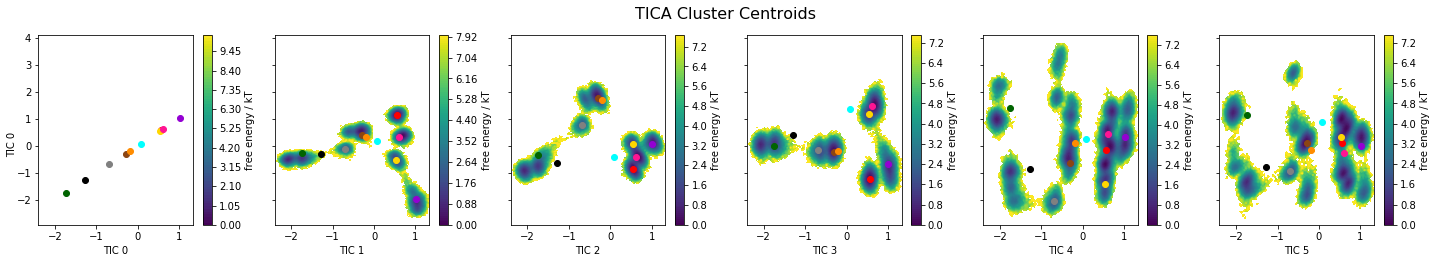

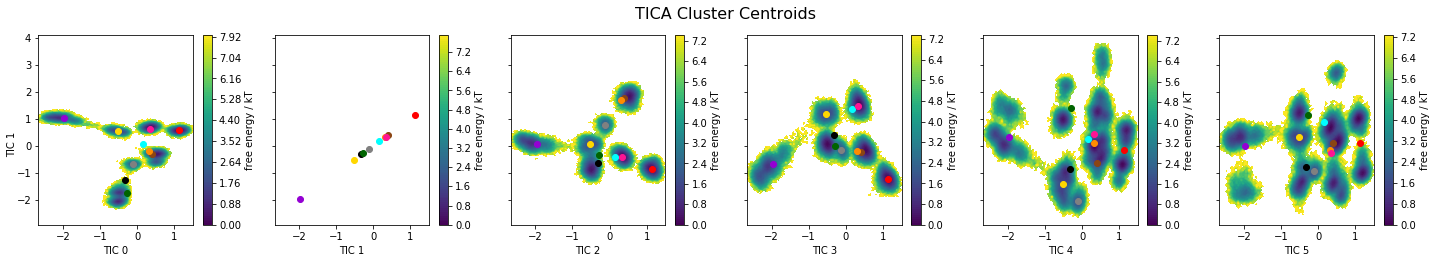

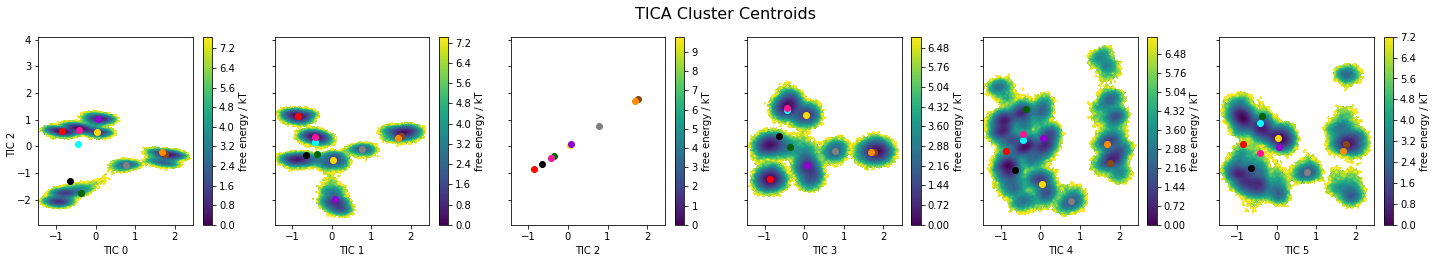

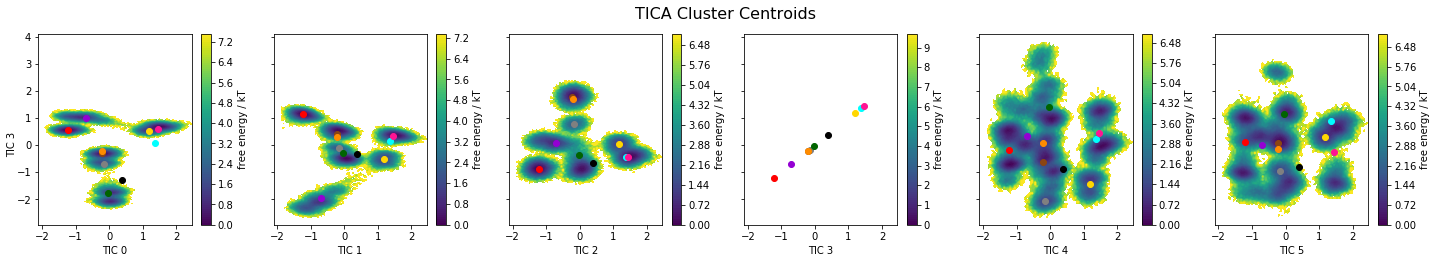

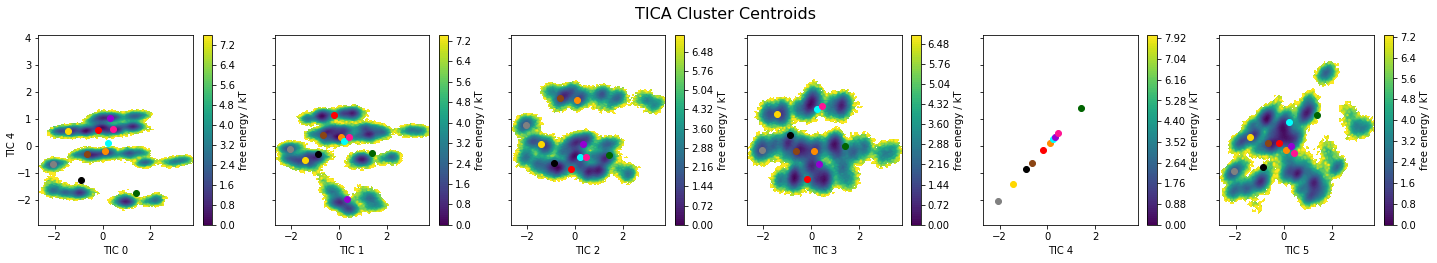

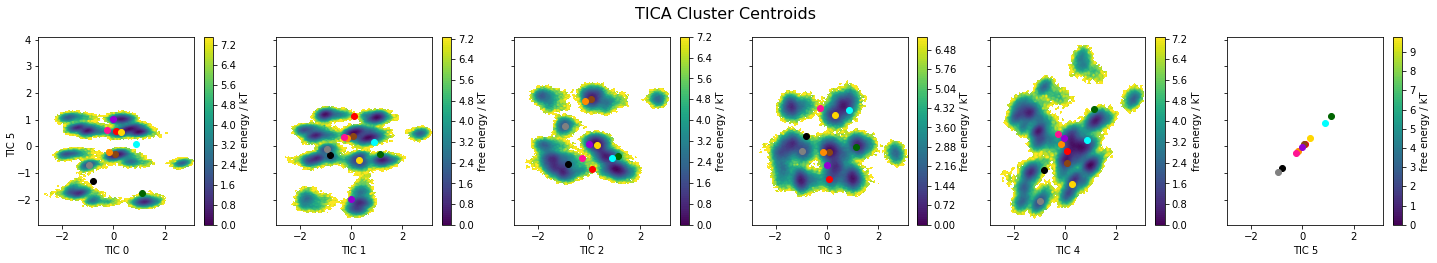

In [5]:
#plotting the free energy in subplots for tics 0-5

for s in range(6):
    fig, ax = plt.subplots(1, 6, sharex='col', sharey='row', figsize = (20,3.4)) #creating 1x6 subplot grid
    
    for w in range(6):
        mplt.plot_free_energy(np.vstack(Y)[:,s], np.vstack(Y)[:,w], ax = ax[w], cmap = 'viridis')#, cbar = False, cbar_label = None)
        cc_x = cl.clustercenters[:,s]
        cc_y = cl.clustercenters[:,w]
        #ax[w].plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='red')
        colors = ['black','gray','red','saddlebrown','darkorange','gold','darkgreen','aqua','darkviolet','deeppink']
        for i in range(10):
            ax[w].scatter(cc_x[i], cc_y[i], color = colors[i])
    
    for a in range(6):
        ax[a].set(xlabel = ('TIC '+str(a)))
        
    fig.text(0.001, 0.5, 'TIC '+str(s), va = 'center', rotation='vertical')
    
    fig.suptitle('TICA Cluster Centroids',fontsize = 16, y=1.06)
    fig.tight_layout()

    plt.savefig('/home/jegan/Clustering_methods/TICA/figs/bkbnpos/TICA_FE_TIC'+str(s)+'.png', bbox_inches = 'tight')


[-1.2847201  -0.6906943   0.56001943 -0.29762718 -0.19678839  0.53936845
 -1.7463845   0.07784742  1.0095465   0.608776  ]
[-0.32433367 -0.11632136  1.1338007   0.39821914  0.31262156 -0.5244022
 -0.2847709   0.15426895 -1.9647629   0.33392844]


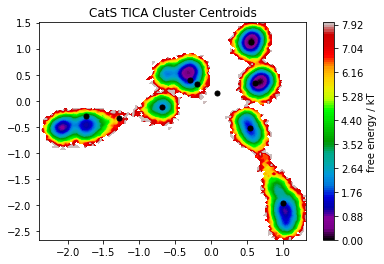

In [6]:
#plots free energy diagram, tic0 and 1
fig, axes= mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')
title("CatS TICA Cluster Centroids" )

fig.savefig("tica_FE_bkbnpos_feat_2.png", dpi = 100)

print(cc_x)
print(cc_y)

[-0.32433367 -0.11632136  1.1338007   0.39821914  0.31262156 -0.5244022
 -0.2847709   0.15426895 -1.9647629   0.33392844]
[-0.64498365  0.77507466 -0.860527    1.7616028   1.6858213   0.04360102
 -0.36256936 -0.43145373  0.07056114 -0.42939192]


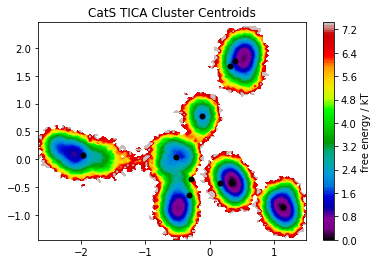

In [7]:
#plots free energy diagram, tic1 and 2
fig, axes= mplt.plot_free_energy(np.vstack(Y)[:,1], np.vstack(Y)[:,2])
cc_x = cl.clustercenters[:,1]
cc_y = cl.clustercenters[:,2]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')
title("CatS TICA Cluster Centroids" )

fig.savefig("tica_FE_bkbnpos_feat_2.1.png", dpi = 100)

print(cc_x)
print(cc_y)

In [8]:
#This tells us how much each feature contributes to each TIC
tica_obj.feature_TIC_correlation

array([[ 0.1951797 ,  0.03178324, -0.03158597, ...,  0.01257657,
        -0.00332635,  0.01588808],
       [-0.13760452, -0.04939033, -0.04113575, ...,  0.00926109,
         0.00845376, -0.01530768],
       [-0.04990494, -0.07354372,  0.09533691, ..., -0.01622335,
        -0.00138098, -0.00301571],
       ...,
       [ 0.00885425,  0.08953706, -0.07478516, ...,  0.00621992,
         0.02955047,  0.00347921],
       [-0.064141  ,  0.01796889, -0.05338888, ...,  0.00314537,
         0.0062144 , -0.00880287],
       [ 0.14382331, -0.08766629,  0.1981003 , ...,  0.00281713,
         0.00930161, -0.02190836]])

In [9]:
#This tells us the number of TICs TICA produces to retain the variance we want, which is .95
tica_obj.cumvar

array([0.04686387, 0.09335933, 0.13917359, ..., 1.        , 1.        ,
       1.        ])

In [14]:
#This prints the discrete trajectories we saved out before, then saves out the percent of frames in each cluster
print(dtrajs)
print(dtrajs[0])

with open('/home/jegan/Clustering_methods/TICA/clusters_bkbnpos.txt', 'w') as newfile:
    numb = []
    for i in range(10):
        frames = []
        for k in dtrajs:
            for p in k:
                if p == i:
                    frames.append(p)

        print(len(frames))
        numb.append(len(frames))
    
    newfile.write('Percent of frames per TICA bkbnpos cluster:\n')
    tot = 0
    index = 0
    for j in numb:
        tot += j
        percent = (j/450000)*100
        num = str(percent)
        newfile.write('Cluster '+ str(index)+' = '+num+' %\n')
        index += 1
    print(tot)
#cl.index_clusters
#shape(cl.index_clusters)
#dtraj=max(dtrajs)
#print(dtraj)

[array([9, 9, 9, ..., 9, 9, 9], dtype=int32), array([2, 2, 2, ..., 2, 2, 2], dtype=int32), array([3, 3, 3, ..., 4, 4, 4], dtype=int32), array([5, 5, 5, ..., 8, 8, 8], dtype=int32), array([1, 1, 1, ..., 6, 6, 6], dtype=int32)]
[9 9 9 ... 9 9 9]
44488
11670
89991
14807
70782
30852
50129
3045
56007
78229
450000


In [11]:
#Extracting Centroids

avg = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

indices = {}
for i in range(len(Y)):
    #for k in range(len(Y[0][i])):
    for k in range(len(Y[i])):
        c = cl.clustercenters[cl.dtrajs[i][k]]
        v = Y[i][k]
        newavg = np.linalg.norm(c-v)
        if avg[cl.dtrajs[i][k]] > newavg:
            avg[cl.dtrajs[i][k]] = newavg
            indices[cl.dtrajs[i][k]] = [i, k]

#trajectory=md.load(['/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md1.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md2.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md3.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md4.nc', '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md5.nc'], top="/net/jam-amaro-shared/bccgc4/Strided_Traj/protein.h5")

z = 0
for key in indices:
        z = z + 1
        index = indices[key][1]*(1 + indices[key][0])
        print(index)
        #i = trajectory[index].topology.select("protein")
        #new_traj = trajectory[index].atom_slice(i)
        #new_traj.save_pdb('/home/jegan/Clustering_methods/TICA/TICA_bkbnpos_feat_joinedtraj_centroids/TICA_%s.pdb' % (z-1))

8956
16806
77220
66191
333604
11040
70083
388975
105084
4325


In [ ]:
8956
44370
302784
83921
11040
182517
333604
35936
105124
388975